# Расчет проводимости трубопроводов с помощью МУК

In [1]:
import os
import math
import numpy as np
from graph import Graph #собственный класс для графиков
from matplotlib import pyplot as plt

## Круглое сечение

### Без разбиения

In [2]:
class Round:
    def __init__(self, L, R = 1):
        self.R = R
        self.L = L
        
    def coaxial_discs(self, s) -> float:
        x = s**2 + self.R**2 + self.R**2
        return 1/(2*self.R**2) * ( x - math.sqrt(x**2 - 4*self.R**2 * self.R**2) )
    
    
    def area_1(self):
        return math.pi * self.R**2
    
    def area_3(self, s):
        if s:
            return 2*math.pi*self.R * s
        return 1
    
    def no_splitting(self) -> float:
        phi_12 = self.coaxial_discs(self.L)
        phi_21 = phi_12
        phi_11, phi_22 = 0, 0
        phi_13 = 1 - phi_11 - phi_12
        
        phi_31 = phi_13 * self.area_1() / self.area_3(self.L)
        phi_32 = phi_31
        phi_33 = 1 - phi_31 - phi_32
        
        k = phi_12 + phi_13 * phi_32 / ( 1 - phi_33 )
        return k
    
    def splitting_2(self) -> float:
        phi_11, phi_55 = 0, 0
        phi_15 = self.coaxial_discs(self.L/2)
        phi_51 = phi_15
        phi_13 = 1 - phi_11 - phi_15

        phi_31 = phi_13 * self.area_1() / self.area_3(self.L/2)
        phi_35 = phi_31
        phi_33 = 1 - phi_31 - phi_35
        phi_53 = 1 - phi_55 - phi_51
        
        phi_52, phi_25 = phi_15, phi_15
        phi_54 = phi_13

        phi_45, phi_42 = phi_31, phi_31
        phi_44 = phi_33
        phi_24 = phi_53
        
        x = phi_54*phi_42/(1 - phi_44) + phi_52
        y = phi_13*phi_35/(1 - phi_33) + phi_15
        z = 1 - phi_53*phi_35/(1 - phi_33) * phi_54*phi_45/(1 - phi_44)
        k = x*y/z
        return k
    
    def splitting_3(self):
        phi_12 = self.coaxial_discs(self.L/3)
        phi_13 = 1 - phi_12
        phi_31 = phi_13 * self.area_1() / self.area_3(self.L/3)
        phi_33 = 1 - 2*phi_31
        
        #Система для потоков
        #Q_6^Л, Q_6^П, Q_7^Л, Q_7^П
        sle = np.array([[1, -phi_13*phi_31/(1-phi_33), 0, 0],
               [-phi_13*phi_31/(1-phi_33), 1, 0, -(phi_12 + phi_13*phi_31/(1-phi_33))],
               [-(phi_12 + phi_13*phi_31/(1-phi_33)), 0, 1, -phi_13*phi_31/(1-phi_33)],
               [0, 0, -phi_13*phi_31/(1-phi_33), 1]])
        
        b = np.array([phi_12 + phi_13*phi_31/(1 - phi_33), 0, 0, 0])
        x = np.linalg.solve(sle,b)
        return (phi_31*phi_13/(1-phi_33) + phi_12)*x[2]

In [3]:
tube_1 = Round(2)
round(tube_1.no_splitting(),3)

0.586

### С разбиением

In [4]:
round(tube_1.splitting_2(),3)

0.528

### Графики

In [5]:
def pop(arr):
    return arr[:-1].copy()

def create_x():
    x = np.linspace(0.1,2,20)
    x = pop(x)
    x = np.concatenate([x,np.linspace(2,5,7)])
    x = pop(x)
    x = np.concatenate([x,np.linspace(5,10,6)])
    return x

In [6]:
#ф-ция строит 3 кривые на одном графике
#и сохраняет график
def lines(x, k_1, k_2, k_3, filename = "", dirname = "", k = []):
    plt.scatter(x, k_1, label= "Без разбиения", marker="o")
    plt.plot(x, k_1)
        
    plt.scatter(x, k_2, label= "Разбиение на 2 части" , marker="o")
    plt.plot(x, k_2)
    
    plt.scatter(x, k_3, label= "Разбиение на 3 части" , marker="o")
    plt.plot(x, k_3)
    
    if len(k) and (type(k) is np.ndarray):
        plt.scatter(x, k, label= "Теоретический", marker="o")
        plt.plot(x, k)
    plt.legend()
    Graph().save(filename, dirname)
    return

#ф-ция строит, называет,
#выводит и сохраняет график
def draw():
    graph= Graph()
    graph.customize_graph("Проводимость в круглом сечении при L/d < 10", "L/d")
    
    x   = create_x()
    k_1 = [Round(element, 1/2).no_splitting() for element in x]
    k_2 = [Round(element, 1/2).splitting_2()  for element in x]
    k_3 = [Round(element, 1/2).splitting_3()  for element in x]
    lines(x, k_1, k_2, k_3, "L less then 10.png", "round", graph.k[1:])
    plt.show()
    return

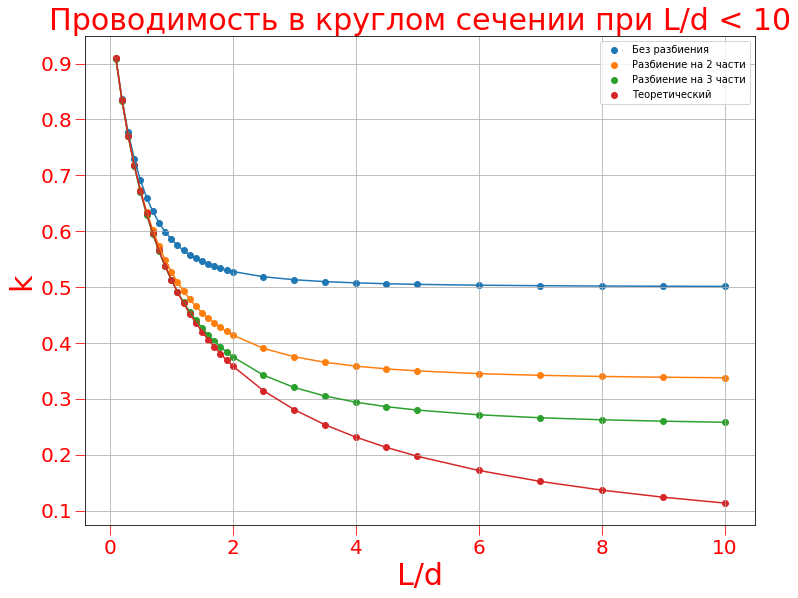

In [7]:
draw()